In [3]:
# @title Mounts drive folder
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/Neuromatch_2025/

/content/drive/MyDrive/Neuromatch_2025


In [ ]:
# @title Imports

!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [6]:
# @title Figure settings
import logging

#interactive display
import ipywidgets as widgets

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

#RNN

In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        return x

class CNNFeatureExtractor(nn.Module):
    def __init__(self, pretrained_cnn_path, feature_dim=512):
        super(CNNFeatureExtractor, self).__init__()

        self.cnn = SimpleCNN()
        self.cnn.load_state_dict(torch.load(pretrained_cnn_path, map_location=device))

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.cnn.eval()
        self.feature_dim = feature_dim

    def forward(self, x):
        with torch.no_grad():
            features = self.cnn.extract_features(x)
        return features


class VisualMemoryModel(nn.Module):
    def __init__(self, pretrained_cnn_path, rnn_hidden_dim=256,
                 projection_dim=128, rnn_type='LSTM', num_layers=2, dropout=0.3):
        super(VisualMemoryModel, self).__init__()

        self.cnn_features = CNNFeatureExtractor(pretrained_cnn_path)
        cnn_feature_dim = self.cnn_features.feature_dim

        self.feature_projection = nn.Sequential(
            nn.Linear(cnn_feature_dim, projection_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(projection_dim * 2, projection_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )

        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                projection_dim, rnn_hidden_dim,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=False
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                projection_dim, rnn_hidden_dim,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=False
            )

        self.memory_classifier = nn.Sequential(
            nn.Linear(rnn_hidden_dim, rnn_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 2)
        )

        self.rnn_hidden_dim = rnn_hidden_dim
        self.num_layers = num_layers
        self.projection_dim = projection_dim

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size * seq_len, *x.shape[2:])
        cnn_features = self.cnn_features(x)
        projected_features = self.feature_projection(cnn_features)
        projected_features = projected_features.view(batch_size, seq_len, -1)

        if self.rnn_type == 'LSTM':
            rnn_output, (hidden, cell) = self.rnn(projected_features)
        else:
            rnn_output, hidden = self.rnn(projected_features)

        final_output = rnn_output[:, -1, :]
        logits = self.memory_classifier(final_output)
        return logits

    def get_attention_weights(self, x):
        """Get attention-like weights to see what the model focuses on"""
        batch_size, seq_len = x.size(0), x.size(1)

        x = x.view(batch_size * seq_len, *x.shape[2:])
        cnn_features = self.cnn_features(x)
        projected_features = self.feature_projection(cnn_features)
        projected_features = projected_features.view(batch_size, seq_len, -1)

        if self.rnn_type == 'LSTM':
            rnn_output, _ = self.rnn(projected_features)
        else:
            rnn_output, _ = self.rnn(projected_features)

        final_state = rnn_output[:, -1:, :]  # [batch_size, 1, hidden_dim]
        attention_scores = torch.bmm(rnn_output, final_state.transpose(1, 2))  # [batch_size, seq_len, 1]
        attention_weights = F.softmax(attention_scores.squeeze(-1), dim=1)  # [batch_size, seq_len]
        return attention_weights

def train_memory_model(model, train_loader, criterion, optimizer, device, epoch):

    model.train()
    model.cnn_features.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    match_correct = 0
    match_total = 0
    nomatch_correct = 0
    nomatch_total = 0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch} Training')

    for batch_idx, (sequences, targets) in enumerate(train_bar):
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Separate accuracy for match vs no-match
        match_mask = (targets == 1)
        nomatch_mask = (targets == 0)

        if match_mask.sum() > 0:
            match_correct += predicted[match_mask].eq(targets[match_mask]).sum().item()
            match_total += match_mask.sum().item()

        if nomatch_mask.sum() > 0:
            nomatch_correct += predicted[nomatch_mask].eq(targets[nomatch_mask]).sum().item()
            nomatch_total += nomatch_mask.sum().item()


        train_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'M': f'{100.*match_correct/max(match_total,1):.1f}%',
            'NM': f'{100.*nomatch_correct/max(nomatch_total,1):.1f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    match_acc = 100. * match_correct / max(match_total, 1)
    nomatch_acc = 100. * nomatch_correct / max(nomatch_total, 1)

    return epoch_loss, epoch_acc, match_acc, nomatch_acc

def test_memory_model(model, test_loader, criterion, device, epoch):
    """Test the model"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    match_correct = 0
    match_total = 0
    nomatch_correct = 0
    nomatch_total = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f'Epoch {epoch} Testing')

        for sequences, targets in test_bar:
            sequences, targets = sequences.to(device), targets.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            match_mask = (targets == 1)
            nomatch_mask = (targets == 0)

            if match_mask.sum() > 0:
                match_correct += predicted[match_mask].eq(targets[match_mask]).sum().item()
                match_total += match_mask.sum().item()

            if nomatch_mask.sum() > 0:
                nomatch_correct += predicted[nomatch_mask].eq(targets[nomatch_mask]).sum().item()
                nomatch_total += nomatch_mask.sum().item()

            test_bar.set_postfix({
                'Loss': f'{test_loss/len(test_loader):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = test_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    match_acc = 100. * match_correct / max(match_total, 1)
    nomatch_acc = 100. * nomatch_correct / max(nomatch_total, 1)

    return epoch_loss, epoch_acc, match_acc, nomatch_acc, all_predictions, all_targets

Using device: cpu


In [8]:
class NoiseGenerator:
    @staticmethod
    def gaussian_noise(shape, noise_level=0.5):
        """Generate Gaussian noise image"""
        noise = torch.randn(shape) * noise_level
        return torch.clamp(noise, 0, 1)

    @staticmethod
    def salt_pepper_noise(shape, noise_density=0.3):
        """Generate salt and pepper noise"""
        noise = torch.rand(shape)
        salt_pepper = torch.zeros_like(noise)
        salt_pepper[noise < noise_density/2] = 0
        salt_pepper[noise > 1 - noise_density/2] = 1
        mask = (noise >= noise_density/2) & (noise <= 1 - noise_density/2)
        salt_pepper[mask] = torch.rand(torch.sum(mask).item()) * 0.5 + 0.25
        return salt_pepper

    @staticmethod
    def random_patches(shape, num_patches=10, patch_size=5):
        """Generate random square patches"""
        noise = torch.rand(shape) * 0.3 + 0.35
        h, w = shape[-2:]

        for _ in range(num_patches):
            x = random.randint(0, max(0, w - patch_size))
            y = random.randint(0, max(0, h - patch_size))
            intensity = random.random()
            noise[..., y:y+patch_size, x:x+patch_size] = intensity

        return noise

    @staticmethod
    def scrambled_mnist(mnist_dataset, scramble_intensity=0.8):
        """Create scrambled version of random MNIST digit"""
        random_idx = random.randint(0, len(mnist_dataset) - 1)
        random_image, _ = mnist_dataset[random_idx]

        if random.random() > scramble_intensity:
            return random_image

        img_np = random_image.squeeze().numpy()
        h, w = img_np.shape

        block_size = random.choice([2, 3, 4])
        for i in range(0, h - block_size, block_size):
            for j in range(0, w - block_size, block_size):
                block = img_np[i:i+block_size, j:j+block_size].flatten()
                np.random.shuffle(block)
                img_np[i:i+block_size, j:j+block_size] = block.reshape(block_size, block_size)

        return torch.tensor(img_np).unsqueeze(0).float()


class VisualMemoryDataset(Dataset):

    def __init__(self, mnist_dataset, num_samples=1000, num_distractors=3,
                 noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
                 match_probability=0.5):

        self.mnist_dataset = mnist_dataset
        self.num_samples = num_samples
        self.num_distractors = num_distractors
        self.noise_types = noise_types
        self.match_probability = match_probability
        self.noise_generator = NoiseGenerator()

        # Pre-generate all samples for consistency during training
        print(f"Generating {num_samples} visual memory samples with {num_distractors} distractors...")
        self.samples = []
        self.labels = []
        self.metadata = []  # Store additional info for analysis

        for i in tqdm(range(num_samples), desc="Creating memory samples"):
            sample, label, meta = self._create_memory_sample()
            self.samples.append(sample)
            self.labels.append(label)
            self.metadata.append(meta)

        # Print dataset statistics
        match_count = sum(self.labels)
        print(f"Dataset created:")
        print(f"  Total samples: {num_samples}")
        print(f"  Match trials: {match_count} ({match_count/num_samples*100:.1f}%)")
        print(f"  No-match trials: {num_samples-match_count} ({(num_samples-match_count)/num_samples*100:.1f}%)")
        print(f"  Sequence length: {num_distractors + 2} (1 target + {num_distractors} distractors + 1 probe)")

    def _create_memory_sample(self):

        target_idx = random.randint(0, len(self.mnist_dataset) - 1)
        target_image, target_digit = self.mnist_dataset[target_idx]

        is_match = random.random() < self.match_probability

        if is_match:
            same_digit_indices = [i for i, (_, digit) in enumerate(self.mnist_dataset) if digit == target_digit]
            if target_idx in same_digit_indices:
                same_digit_indices.remove(target_idx)

            if len(same_digit_indices) > 0:
                probe_idx = random.choice(same_digit_indices)
                probe_image, probe_digit = self.mnist_dataset[probe_idx]
            else:
                probe_image, probe_digit = target_image.clone(), target_digit

            label = 1
        else:

            while True:
                probe_idx = random.randint(0, len(self.mnist_dataset) - 1)
                probe_image, probe_digit = self.mnist_dataset[probe_idx]
                if probe_digit != target_digit:
                    break

            label = 0

        sequence = [target_image]

        for i in range(self.num_distractors):
            noise_type = random.choice(self.noise_types)
            noise_image = self._generate_noise_image(target_image.shape, noise_type)
            sequence.append(noise_image)

        sequence.append(probe_image)

        sequence_tensor = torch.stack(sequence)

        metadata = {
            'target_digit': target_digit,
            'probe_digit': probe_digit,
            'is_match': is_match,
            'target_idx': target_idx,
            'probe_idx': probe_idx if not is_match else probe_idx,
            'sequence_length': len(sequence)
        }

        return sequence_tensor, label, metadata

    def _generate_noise_image(self, shape, noise_type):
        """Generate a single noise/distractor image"""
        if noise_type == 'gaussian':
            return self.noise_generator.gaussian_noise(shape, noise_level=0.6)
        elif noise_type == 'salt_pepper':
            return self.noise_generator.salt_pepper_noise(shape, noise_density=0.4)
        elif noise_type == 'patches':
            return self.noise_generator.random_patches(shape, num_patches=15, patch_size=4)
        elif noise_type == 'scrambled':
            return self.noise_generator.scrambled_mnist(self.mnist_dataset, scramble_intensity=0.8)
        else:
            # Default to gaussian noise
            return self.noise_generator.gaussian_noise(shape, noise_level=0.5)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns:
            sequence: Tensor of shape [seq_len, 1, 28, 28]
                     [target, distractor1, distractor2, ..., probe]
            label: Integer (1 for match, 0 for no-match)
        """
        return self.samples[idx], self.labels[idx]

    def get_sample_with_metadata(self, idx):
        """Get sample with additional metadata for analysis"""
        return self.samples[idx], self.labels[idx], self.metadata[idx]

    def get_statistics(self):
        """Get dataset statistics"""
        match_count = sum(self.labels)
        total = len(self.labels)

        # Count digits used
        target_digits = [meta['target_digit'] for meta in self.metadata]
        probe_digits = [meta['probe_digit'] for meta in self.metadata]

        from collections import Counter
        target_counter = Counter(target_digits)
        probe_counter = Counter(probe_digits)

        return {
            'total_samples': total,
            'match_trials': match_count,
            'nomatch_trials': total - match_count,
            'match_percentage': match_count / total * 100,
            'target_digit_distribution': dict(target_counter),
            'probe_digit_distribution': dict(probe_counter),
            'sequence_length': self.num_distractors + 2
        }


def demonstrate_visual_memory_task():
    """Demonstrate how the visual memory task works"""

    print("="*60)
    print("VISUAL MEMORY TASK DEMONSTRATION")
    print("="*60)

    # Create a small dataset for demonstration
    demo_dataset = VisualMemoryDataset(
        mnist_train,
        num_samples=10,  # Small for demo
        num_distractors=3,
        noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
        match_probability=0.5
    )

    # Show statistics
    stats = demo_dataset.get_statistics()
    print(f"\nDataset Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

    # Visualize some samples
    print(f"\nVisualizing samples...")
    visualize_memory_samples(demo_dataset, num_samples=3)

    # Test with DataLoader
    print(f"\nTesting with DataLoader:")
    dataloader = DataLoader(demo_dataset, batch_size=4, shuffle=True)

    for batch_idx, (sequences, labels) in enumerate(dataloader):
        print(f"  Batch {batch_idx + 1}:")
        print(f"    Sequences shape: {sequences.shape}")  # [batch_size, seq_len, 1, 28, 28]
        print(f"    Labels shape: {labels.shape}")        # [batch_size]
        print(f"    Labels: {labels.tolist()}")
        print(f"    Match trials in batch: {(labels == 1).sum().item()}/{len(labels)}")
        break

def visualize_memory_samples(dataset, num_samples=5):
    """Visualize memory task samples with detailed annotations"""

    fig, axes = plt.subplots(num_samples, 6, figsize=(15, num_samples * 2.5))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Visual Memory Task Samples', fontsize=16)

    for i in range(num_samples):
        sequence, label, metadata = dataset.get_sample_with_metadata(i)
        seq_len = sequence.shape[0]

        target_digit = metadata['target_digit']
        probe_digit = metadata['probe_digit']
        is_match = metadata['is_match']

        print(f"\nSample {i+1}:")
        print(f"  Target digit: {target_digit}")
        print(f"  Probe digit: {probe_digit}")
        print(f"  Result: {'MATCH' if is_match else 'NO MATCH'}")
        print(f"  Label: {label}")

        # Display sequence
        for j in range(min(seq_len, 6)):  # Show up to 6 images
            ax = axes[i, j]
            img = sequence[j].squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')

            if j == 0:
                # Target image
                ax.set_title(f'TARGET\n(digit: {target_digit})',
                           fontweight='bold', color='blue', fontsize=10)
                ax.add_patch(plt.Rectangle((0, 0), 27, 27, fill=False,
                                         edgecolor='blue', linewidth=2))
            elif j == seq_len - 1:
                # Probe image
                match_text = 'MATCH' if is_match else 'NO MATCH'
                color = 'green' if is_match else 'red'
                ax.set_title(f'PROBE\n(digit: {probe_digit})\n{match_text}',
                           fontweight='bold', color=color, fontsize=9)
                ax.add_patch(plt.Rectangle((0, 0), 27, 27, fill=False,
                                         edgecolor=color, linewidth=2))
            else:
                # Distractor image
                ax.set_title(f'NOISE {j}', color='gray', fontsize=9)

        # Hide unused subplots
        for j in range(seq_len, 6):
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def create_datasets_for_training(train_size=3000, test_size=1000, num_distractors=3):
    """Create properly sized datasets for actual training"""

    print("="*60)
    print("CREATING TRAINING DATASETS")
    print("="*60)

    # Training dataset
    print("Creating training dataset...")
    train_memory_dataset = VisualMemoryDataset(
        mnist_train,
        num_samples=train_size,
        num_distractors=num_distractors,
        noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
        match_probability=0.5
    )

    # Testing dataset
    print("\nCreating testing dataset...")
    test_memory_dataset = VisualMemoryDataset(
        mnist_test,
        num_samples=test_size,
        num_distractors=num_distractors,
        noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
        match_probability=0.5
    )

    # Create DataLoaders
    train_loader = DataLoader(train_memory_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_memory_dataset, batch_size=32, shuffle=False)

    print(f"\nDatasets ready for training!")
    print(f"Training samples: {len(train_memory_dataset)}")
    print(f"Testing samples: {len(test_memory_dataset)}")
    print(f"Sequence length: {num_distractors + 2}")

    return train_memory_dataset, test_memory_dataset, train_loader, test_loader

#Fixed points finder

In [9]:
def find_fixed_point(cell_fn, x, h0=None, c0=None, lr=1e-2, steps=500, rnn_type='LSTM'):
    """
    Find a fixed point (h*, c*) such that (h*, c*) = cell_fn(h*, c*, x).

    Args:
        cell_fn: Callable LSTM cell (like model.rnn)
            It takes (h, c, x) and returns (h_next, c_next).
        x:  torch.Tensor
            Input of shape [1, input_dim] (projected input)
        h0: torch.Tensor, optional
            Initial guess for hidden state of shape [batch_size, hidden_dim].
        c0: torch.Tensor, optional
            Initial guess for cell state tensor of shape [batch_size, hidden_dim].
        lr: float
            Learning rate for optimizer
        steps: int
            Number of optimization steps to minimize the distance to the fixed point.

    Returns:
        h_fixed: torch.Tensor
            The fixed-point hidden state.
        c_fixed: torch.Tensor
            The fixed-point cell state.
        loss_trace: list of float
            Optimization loss over time for converge analysis.
    """

    # Initialize h and c with gradients so we can optimize them
    h = h0 if h0 is not None else torch.randn(1, x.shape[1], device=device, requires_grad=True)
    h = h.clone().detach().requires_grad_(True)

    if rnn_type.upper() == 'LSTM':
        c = c0 if c0 is not None else torch.randn_like(h, device=device, requires_grad=True)
        c = c.clone().detach().requires_grad_(True)
        params = [h, c]
    else:
        params = [h]

    # Use Adam to optimize h and c such that LSTM(h, c, x) = (h, c)
    # Update h and c to minimize the fixed point loss
    optimizer = torch.optim.Adam(params, lr=lr)

    # For storing the loss at each step (to visualize convergence later)
    loss_trace = []
    h_trajectory = []
    c_trajectory = []

    # Optimization loop
    for i in range(steps):
        optimizer.zero_grad() # Reset gradients

        if rnn_type.upper() == 'LSTM':
            # Forward pass through the LSTM cell
            h_next, c_next = cell_fn(h, c, x)
            # Define loss as the squared distance between (h_next, c_next) and (h, c)
            # This loss is minimized when the hidden and cell states do not change — i.e., fixed point
            loss = 0.5 * ((h_next - h).norm()**2 + (c_next - c).norm()**2)
        else:# GRU or RNN
            h_next = cell_fn(h, x)
            loss = 0.5 * (h_next - h).norm()**2

        # Backpropagate the loss to compute gradients
        loss.backward(retain_graph=True)

        # Update h and c using the gradients
        optimizer.step()

        # Record the loss value
        loss_trace.append(loss.item())
        h_trajectory.append(h.detach().cpu().clone())

        # Optionally print progress every 50 steps
        #if i % 50 == 0:
        #    print(f"Iter {i}: Loss = {loss.item():.6f}")
    if rnn_type.upper() == 'LSTM':
        return h.detach(), c.detach(), loss_trace, h_trajectory, c_trajectory
    else:
        return h.detach(), None, loss_trace, h_trajectory, None


In [10]:
def compute_jacobian_eigenvalues(cell_fn, h_fixed, c_fixed, x, rnn_type='LSTM'):
    h_fixed = h_fixed.detach().clone().requires_grad_(True)
    if rnn_type == 'LSTM' and c_fixed is not None:
        c_fixed = c_fixed.detach().clone().requires_grad_(True)
        h_next, c_next = cell_fn(h_fixed, c_fixed, x)
    else:
        h_next = cell_fn(h_fixed, x)

    hidden_dim = h_fixed.shape[1]
    jacobian = torch.zeros(hidden_dim, hidden_dim)

    for i in range(hidden_dim):
        grad = torch.autograd.grad(
            h_next[0, i], h_fixed,
            retain_graph=True,
            create_graph=False
        )[0][0]
        jacobian[i] = grad

    eigenvals = torch.linalg.eigvals(jacobian).detach().cpu().numpy()
    return eigenvals


In [11]:
def find_multiple_fixed_points(rnn_hidden_dim, cell_fn, x, num_points=50, threshold=1e-4, rnn_type='LSTM', **kwargs):
    fixed_points = []
    losses = []
    eigenvalues_list = []

    for i in range(num_points):
        h0=2*torch.rand(1, model.rnn_hidden_dim, device=device)+1
        c0=2*torch.rand(1, model.rnn_hidden_dim, device=device)+1
        h_fixed, c_fixed, loss_trace, h_traj, c_traj = find_fixed_point(
            cell_fn, x, h0=h0, c0=None, rnn_type=rnn_type, **kwargs
        )

        if loss_trace[-1] < threshold:
            eigenvals = compute_jacobian_eigenvalues(cell_fn, h_fixed, c_fixed, x, rnn_type)
            if rnn_type == 'LSTM':
                if h_fixed is not None and c_fixed is not None:
                    fixed_points.append((h_fixed.detach(), c_fixed.detach()))
                    losses.append(loss_trace)
                    eigenvalues_list.append(eigenvals)
            else:
                if h_fixed is not None:
                    fixed_points.append(h_fixed.detach())
                    losses.append(loss_trace)
                    eigenvalues_list.append(eigenvals)

            print(f"✓ Fixed point {len(fixed_points)} found (final loss: {loss_trace[-1]:.2e})")
            #print(h_fixed.detach())
        else:
            print(f"✗ Trial {i+1} did not converge (final loss: {loss_trace[-1]:.2e})")

    return fixed_points, losses, eigenvalues_list, h_traj, c_traj

In [12]:
def get_single_rnn_cell(model):
    """
    Extracts the first-layer RNN cell from the model's RNN module.
    Returns a callable:
      - LSTM: f(h, c, x) -> (h', c')
      - GRU or RNN: f(h, x) -> h'
    """
    # If the model uses an LSTM layer
    if isinstance(model.rnn, nn.LSTM):
        # Extract the weights and biases of the input-to-hidden and
        # hidden-to-hidden connections
        weight_ih = model.rnn.weight_ih_l0
        weight_hh = model.rnn.weight_hh_l0
        bias_ih = model.rnn.bias_ih_l0
        bias_hh = model.rnn.bias_hh_l0

        # Define a manual LSTM cell function
        def lstm_cell(h, c, x):
            # Compute all gates in one linear transformation for efficiency
            gates = F.linear(x, weight_ih, bias_ih) + F.linear(h, weight_hh, bias_hh)
            # Split gates into input gate (i), forget gate (f), cell candidate (g), output gate (o)
            i, f, g, o = gates.chunk(4, 1)
            # Apply activations
            i, f, g, o = torch.sigmoid(i), torch.sigmoid(f), torch.tanh(g), torch.sigmoid(o)
            # Update cell state
            c_next = f * c + i * g
            # Compute new hidden state
            h_next = o * torch.tanh(c_next)
            return h_next, c_next

        return lstm_cell

    # If the model uses a GRU layer
    elif isinstance(model.rnn, nn.GRU):
        # Use PyTorch's GRUCell for single-step computation
        cell = nn.GRUCell(model.rnn.input_size, model.rnn.hidden_size)
        # Load parameters from the model into the cell
        cell.load_state_dict({
            'weight_ih': model.rnn.weight_ih_l0,
            'weight_hh': model.rnn.weight_hh_l0,
            'bias_ih': model.rnn.bias_ih_l0,
            'bias_hh': model.rnn.bias_hh_l0
        })
        return lambda h, x: cell(x, h)

    # If the model uses a vanilla RNN layer
    elif isinstance(model.rnn, nn.RNN):
        # Use PyTorch's RNNCell for single-step computation
        cell = nn.RNNCell(model.rnn.input_size, model.rnn.hidden_size)
        # Load weights into the cell
        cell.load_state_dict({
            'weight_ih': model.rnn.weight_ih_l0,
            'weight_hh': model.rnn.weight_hh_l0,
            'bias_ih': model.rnn.bias_ih_l0,
            'bias_hh': model.rnn.bias_hh_l0
        })
        return lambda h, x: cell(x, h)

    else:
        raise ValueError("Unsupported RNN type")

In [13]:
def plot_eigenvalues(eigenvalues_list):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title("Eigenvalues of Fixed Point Jacobians")
    ax.set_xlabel("Real part")
    ax.set_ylabel("Imaginary part")
    ax.axvline(0, color='gray', lw=0.5)
    ax.axhline(0, color='gray', lw=0.5)
    unit_circle = plt.Circle((0, 0), 1, color='black', fill=False, linestyle='--', alpha=0.6)
    ax.add_artist(unit_circle)

    for eigs in eigenvalues_list:
        ax.plot(eigs.real, eigs.imag, 'o', alpha=0.7)

    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    plt.grid(True)
    plt.show()


#Compute fixed points

In [14]:
import pickle

pretrained_cnn_path = "/content/drive/MyDrive/Neuromatch_2025/small_cnn_model.pth"
pretrained_rnn_path = "/content/drive/MyDrive/Neuromatch_2025/visual_memory_GRU_noise7.pth"
rnn_type='GRU'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisualMemoryModel(pretrained_cnn_path=pretrained_cnn_path, rnn_type=rnn_type)
model.to(device)  # Make sure model is on correct device

#Load the full model weights (including the trained RNN)
rnn_state = torch.load(pretrained_rnn_path, map_location=device)
model.load_state_dict(rnn_state)

model.eval()
#verify the weights loaded correctly
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad} | mean={param.data.mean():.4f}")

# Get RNN cell
rnn_cell = get_single_rnn_cell(model)
#-------------------
# Define the path to the saved test dataset
test_dataset_path = '/content/drive/MyDrive/Neuromatch_2025/test_visual_memory_dataset.pkl'

# Load the test dataset
print(f"Loading test dataset from: {test_dataset_path}")

with open(test_dataset_path, 'rb') as f:
    test_visual_memory_dataset = pickle.load(f)

print("✅ Test dataset loaded successfully!")

# Get an example sample from the dataset
# The dataset returns a sequence and a label
example_sequence, example_label = test_visual_memory_dataset[0] # You can change the index

print(f"\nExample sequence shape: {example_sequence.shape}")
print(f"Example label: {example_label}")

# If you want to visualize the sequence, you can use the visualize_memory_samples function
# For example:
# visualize_memory_samples(test_visual_memory_dataset, num_samples=1)

# Process each image in the sequence through the CNN individually
sequence_length = example_sequence.shape[0]
cnn_features_list = []
with torch.no_grad(): # Ensure no gradients are computed for CNN features
    for i in range(sequence_length):
        single_image = example_sequence[i].unsqueeze(0).to(device) # Add batch dimension
        features = model.cnn_features(single_image)
        cnn_features_list.append(features)

# Stack the features to get a tensor of shape [sequence_length, feature_dim]
stacked_cnn_features = torch.cat(cnn_features_list, dim=0)

# Project to RNN input space
x_proj_sequence = model.feature_projection(stacked_cnn_features)

x_proj_single_input = x_proj_sequence[0].unsqueeze(0)

#-------------------

# Initial hidden and cell states
# h0 = torch.randn(2, model.rnn_hidden_dim, device=device) # Not needed for GRU single cell
# c0 = torch.randn(2, model.rnn_hidden_dim, device=device) # Not needed for GRU

# Run fixed point finder
# The fixed point finder expects a single input, not a sequence
h_fp, c_fp, loss_trace, h_traj, c_traj = find_fixed_point(
    rnn_cell, x_proj_single_input, h0=torch.randn(1, model.rnn_hidden_dim, device=device), c0=None,  # only pass c0 if LSTM
    lr=1e-2, steps=500, rnn_type=rnn_type)

print(f"\nFixed point hidden state shape: {h_fp.shape}")
if c_fp is not None:
    print(f"Fixed point cell state shape: {c_fp.shape}")

# Plot loss trace
#plt.figure(figsize=(10, 5))
#plt.plot(loss_trace)
#plt.xlabel("Optimization Steps")
#plt.ylabel("Fixed Point Loss")
#plt.title("Fixed Point Optimization Loss Trace")
#plt.grid(True)
#plt.show()

cnn_features.cnn.conv1.weight: False | mean=-0.0075
cnn_features.cnn.conv1.bias: False | mean=-0.0667
cnn_features.cnn.conv2.weight: False | mean=-0.0124
cnn_features.cnn.conv2.bias: False | mean=-0.0159
cnn_features.cnn.conv3.weight: False | mean=-0.0166
cnn_features.cnn.conv3.bias: False | mean=-0.0351
cnn_features.cnn.fc1.weight: False | mean=-0.0034
cnn_features.cnn.fc1.bias: False | mean=-0.0101
cnn_features.cnn.fc2.weight: False | mean=-0.0113
cnn_features.cnn.fc2.bias: False | mean=-0.0021
feature_projection.0.weight: True | mean=-0.0005
feature_projection.0.bias: True | mean=-0.0039
feature_projection.3.weight: True | mean=-0.0004
feature_projection.3.bias: True | mean=-0.0083
rnn.weight_ih_l0: True | mean=-0.0001
rnn.weight_hh_l0: True | mean=-0.0000
rnn.bias_ih_l0: True | mean=0.0029
rnn.bias_hh_l0: True | mean=0.0026
rnn.weight_ih_l1: True | mean=0.0000
rnn.weight_hh_l1: True | mean=-0.0001
rnn.bias_ih_l1: True | mean=0.0019
rnn.bias_hh_l1: True | mean=0.0015
memory_classifi

In [15]:
#@title Run fixed-points finder
fixed_points, losses, eigenvalues_list, h_traj, c_traj = find_multiple_fixed_points(
    rnn_hidden_dim = model.rnn_hidden_dim,
    cell_fn=rnn_cell,
    x=x_proj_single_input,
    num_points=100,
    steps=20000,
    lr=1e-2,
    threshold=2e-4,
    rnn_type=rnn_type
)

# Save as a dictionary
data_to_save = {
    "fixed_points": fixed_points,
    "losses": losses,
    "eigenvalues": eigenvalues_list,
    "h_traj": h_traj,
    "c_traj": c_traj
}

torch.save(data_to_save, f"fixed_points_data_7_{rnn_type}.pt")

✓ Fixed point 1 found (final loss: 1.37e-08)
✓ Fixed point 2 found (final loss: 1.73e-06)
✓ Fixed point 3 found (final loss: 6.32e-10)
✓ Fixed point 4 found (final loss: 9.42e-10)
✓ Fixed point 5 found (final loss: 3.40e-05)
✓ Fixed point 6 found (final loss: 1.04e-05)
✓ Fixed point 7 found (final loss: 5.36e-07)
✓ Fixed point 8 found (final loss: 6.14e-08)
✓ Fixed point 9 found (final loss: 1.03e-07)
✓ Fixed point 10 found (final loss: 8.57e-06)
✓ Fixed point 11 found (final loss: 4.46e-06)
✓ Fixed point 12 found (final loss: 3.87e-09)
✓ Fixed point 13 found (final loss: 1.13e-09)
✓ Fixed point 14 found (final loss: 2.31e-06)
✓ Fixed point 15 found (final loss: 3.06e-06)
✓ Fixed point 16 found (final loss: 1.69e-10)
✓ Fixed point 17 found (final loss: 1.04e-07)
✓ Fixed point 18 found (final loss: 1.51e-06)
✓ Fixed point 19 found (final loss: 6.89e-08)
✓ Fixed point 20 found (final loss: 2.42e-08)
✓ Fixed point 21 found (final loss: 4.17e-06)
✓ Fixed point 22 found (final loss: 1.07e-0

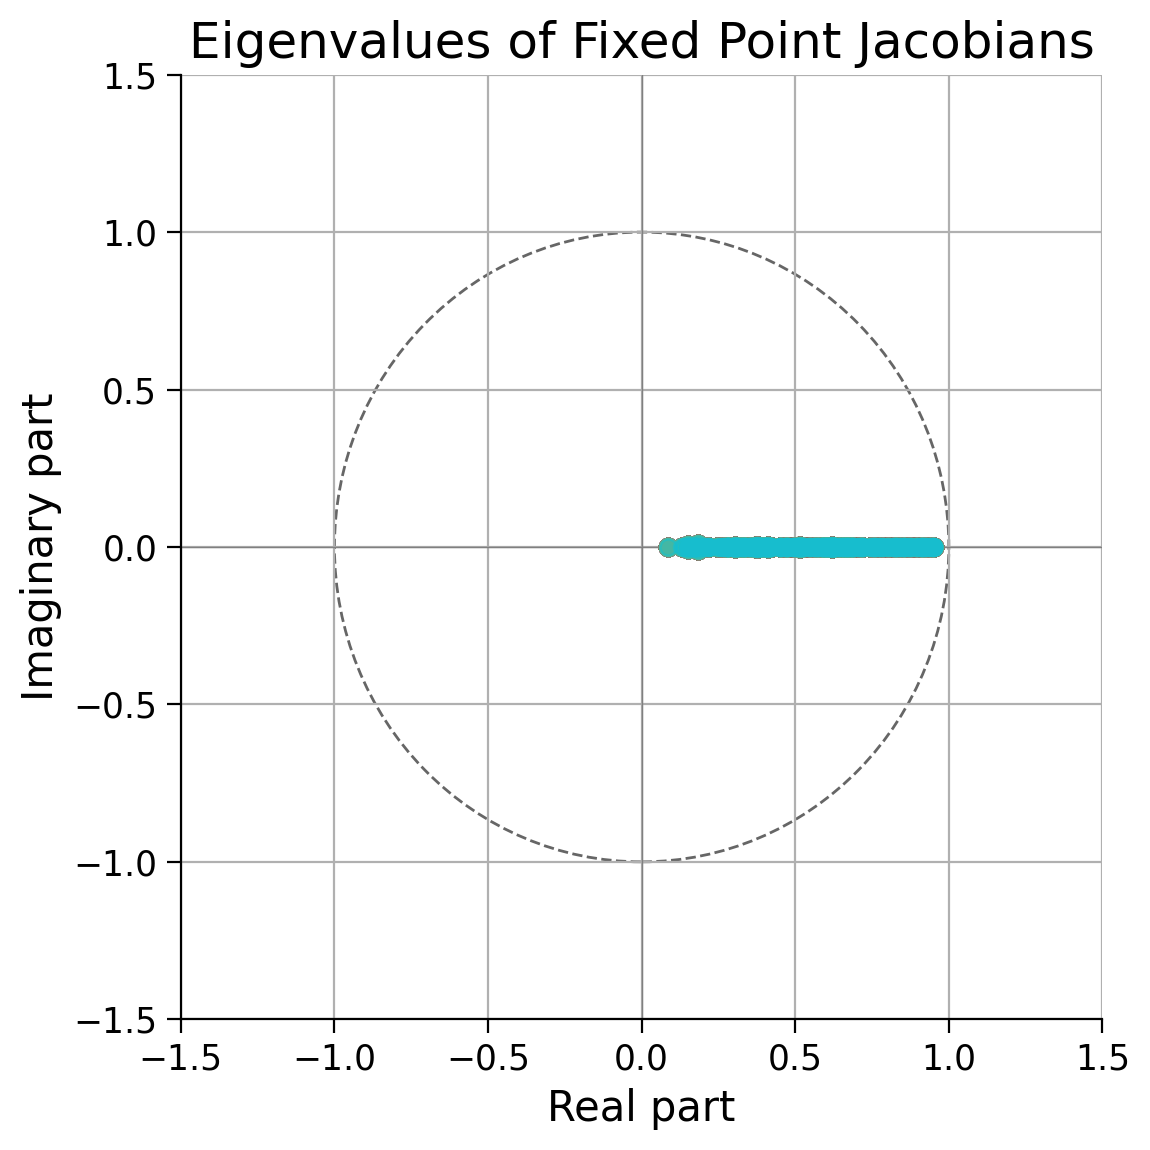

In [16]:
plot_eigenvalues(eigenvalues_list)

###Imports (fixed points visualization)

In [ ]:
!pip install ipympl

#Restart session

In [12]:
from google.colab import output
output.enable_custom_widget_manager()

In [1]:
import ipympl

%matplotlib widget

In [10]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import torch
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# @title load fixed points

data = torch.load("/content/drive/MyDrive/Neuromatch_2025/fixed_points_data_7_GRU.pt", weights_only=False)

fixed_points = data["fixed_points"]
losses = data["losses"]
eigenvalues_list = data["eigenvalues"]
h_traj = data["h_traj"]
c_traj = data["c_traj"]

In [2]:
def plot_fixed_points_pca_3d(fixed_points, eigenvalues_list=None, trajectories=None, title="Fixed Points in PCA Space (3D)", save_path=None):
    from matplotlib import cm

    if isinstance(fixed_points, list):
        fixed_points = torch.cat(
        [fp[0].unsqueeze(0) if isinstance(fp, tuple) else fp.unsqueeze(0) for fp in fixed_points],
        dim=0
    )

    fixed_np = fixed_points.detach().cpu().numpy()
    """
    if trajectories is not None:
        if isinstance(trajectories, list):
            trajectories = torch.cat(trajectories, dim=0)
        traj_np = trajectories.detach().cpu().numpy()
        data_for_pca = np.vstack([fixed_np, traj_np])
    else:
        data_for_pca = fixed_np
    """
    # Balance PCA contribution between fixed points and trajectories
    if trajectories is not None:
        if isinstance(trajectories, list):
            trajectories = torch.cat(trajectories, dim=0)
        traj_np = trajectories.detach().cpu().numpy()

        # Optionally replicate fixed points to give them equal PCA weight
        fixed_weight = max(1, traj_np.shape[0] // fixed_np.shape[0])
        data_for_pca = np.vstack([fixed_np] * fixed_weight + [traj_np])
    else:
        data_for_pca = fixed_np


    pca = PCA(n_components=3)
    data_pca = pca.fit_transform(data_for_pca)

    X_fp_pca = data_pca[:fixed_np.shape[0]]
    X_traj_pca = data_pca[fixed_np.shape[0]:] if trajectories is not None else None


    fig = plt.figure()#figsize=(8, 7)
    ax = fig.add_subplot(111, projection='3d')

    # Color by stability
    if eigenvalues_list is not None:
        #stability_classes = [stability for (_, stability) in eigenvalues_list]
        stability_classes = []
        for eigvals in eigenvalues_list:
            max_abs = np.max(np.abs(eigvals))
            if max_abs < 1:
                stability_classes.append("stable")
            elif max_abs > 1:
                stability_classes.append("unstable")
            else:
                stability_classes.append("saddle")
        color_map = {'stable': 'green', 'unstable': 'red', 'saddle': 'blue'}
        for i, point in enumerate(X_fp_pca):
            color = color_map.get(stability_classes[i], 'blue')
            ax.scatter(point[0], point[1], point[2], c=color, s=50)
    else:
        ax.scatter(X_fp_pca[:, 0], X_fp_pca[:, 1], X_fp_pca[:, 2], c='blue', s=50) #label='Fixed Points',


    if X_traj_pca is not None:
        ax.plot(X_traj_pca[:, 0], X_traj_pca[:, 1], X_traj_pca[:, 2], color='gray', alpha=0.5, label='Trajectory')

    ax.set_title(title)
    ax.set_xlabel("PC 1", labelpad=15)
    ax.set_ylabel("PC 2", labelpad=15)
    ax.set_zlabel("PC 3", labelpad=15)
    #ax.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)

    plt.show()

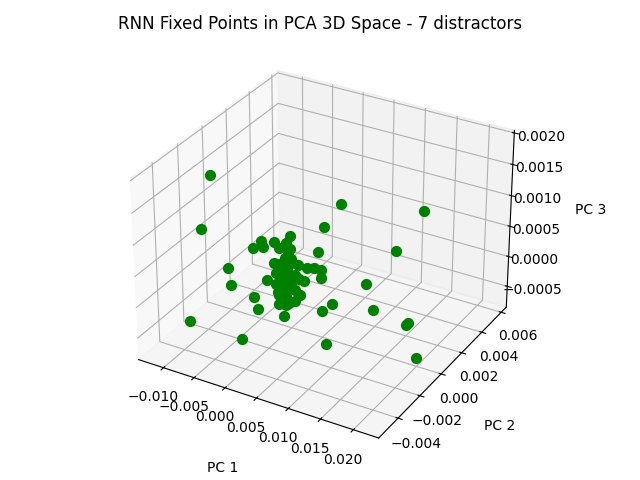

In [13]:
fixed_points_h = [fp[0] for fp in fixed_points]
plot_fixed_points_pca_3d(fixed_points_h, eigenvalues_list, trajectories=None, title="RNN Fixed Points in PCA 3D Space - 7 distractors", save_path="/content/drive/MyDrive/Neuromatch_2025/fixed_points_pca_7d.png")

In [14]:
#@title classify fixed points
def classify_fixed_points(eigenvalues_list):
    classifications = []
    for i, n in enumerate(eigenvalues_list):
        eigvals = eigenvalues_list[i]
        abs_eigs = np.abs(eigvals)
        real_eigs = np.real(eigvals)

        n_stable = np.sum(abs_eigs < 1)
        n_unstable = np.sum(abs_eigs > 1)
        n_marginal = np.sum(abs_eigs == 1)

        if n_stable == len(eigvals):
            if np.any(np.iscomplex(eigvals)):
                stability = "Stable Spiral"
            else:
                stability = "Stable Node"
        elif n_unstable == len(eigvals):
            if np.any(np.iscomplex(eigvals)):
                stability = "Unstable Spiral"
            else:
                stability = "Unstable Node"
        elif n_stable > 0 and n_unstable > 0:
            stability = "Saddle Point"
        elif n_marginal == len(eigvals):
            stability = "Center"
        else:
            stability = "Mixed"

        classifications.append({
            "index": i,
            "n_stable": n_stable,
            "n_unstable": n_unstable,
            "stability": stability
        })

    return classifications

from collections import Counter

results = classify_fixed_points(eigenvalues_list)
stability_counts = Counter([r['stability'] for r in results])

print("Stability Type Distribution:")
for k, v in stability_counts.items():
    print(f"{k}: {v} fixed points")



Stability Type Distribution:
Stable Spiral: 100 fixed points
